In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
import os
import pickle

In [36]:
"""
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'B', 'C', 'D', 'F', 'G', 'H', 'J',
           'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T',
            'V', 'W', 'X', 'Y', 'Z']  #these were the classses used, in case label encoder was missing.
"""

label_encoder_path = 'label_encoder_without_vowels.pkl'
with open(label_encoder_path, 'rb') as encoder_file:
    label_encoder = pickle.load(encoder_file)

print("LabelEncoder has been loaded successfully.")

LabelEncoder has been loaded successfully.


In [37]:
number_of_neighbors = 20    
knn_model_filename = 'knn_model'+str(number_of_neighbors)+'.pkl'
knn = joblib.load(knn_model_filename) #load the model

#load the LabelEncoder to convert predictions back to letters
label_encoder_filename = 'label_encoder.pkl'
label_encoder = joblib.load(label_encoder_filename)

In [38]:
#function to preprocess the image
def preprocess_image(image_path, img_size=20):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load the image at {image_path}")
    img_resized = cv2.resize(img, (img_size, img_size))
    img_flattened = img_resized.flatten().reshape(1, -1)
    return img_flattened

#function to predict the character of an individual blob image
def predict_plate_digit(image_path, knn_model, label_encoder):
    img_preprocessed = preprocess_image(image_path)
    predicted_label = knn_model.predict(img_preprocessed)
    predicted_character = label_encoder.inverse_transform(predicted_label)
    return predicted_character[0]

#function to predict the full plate by combining predictions from blob_1 to blob_7
def predict_full_plate(plate_folder_path, knn_model, label_encoder):
    predicted_plate = ''
    
    for i in range(1, 8):  #assuming 7 blobs (blob_1 to blob_7)
        blob_filename = f'blob_{i}.jpg'
        blob_path = os.path.join(plate_folder_path, blob_filename)
        
        if os.path.exists(blob_path):
            predicted_char = predict_plate_digit(blob_path, knn_model, label_encoder)
            predicted_plate += predicted_char
        else:
            print(f"Warning: {blob_path} does not exist.")
    
    return predicted_plate

#function to visualize the full plate prediction with the ground truth
def visualize_full_plate(plate_image_path, predicted_plate, actual_plate):
    img = cv2.imread(plate_image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not load the image at {plate_image_path}")
    
    # Display the plate image along with ground truth and predicted plate
    plt.imshow(img, cmap='gray')
    plt.title(f'Ground Truth: {actual_plate}\nPredicted: {predicted_plate}')
    plt.axis('off')
    plt.show()

#main function to process and visualize all plates
def process_all_plates(plate_digits_folder, plate_images_folder, knn_model, label_encoder):
    correct_predictions = 0
    total_characters = 0
    
    #traverse the 'frontal' and 'lateral' folders inside 'PlateDigits'
    for plate_type in ['frontal', 'lateral']:
        plate_type_folder = os.path.join(plate_digits_folder, plate_type)
        
        #iterate through each license plate folder inside 'frontal' or 'lateral'
        for root, dirs, _ in os.walk(plate_type_folder):
            for dir_name in dirs:
                plate_folder_path = os.path.join(root, dir_name)
                
                #the actual plate number is derived from the folder name, removing the '.jpg' extension
                actual_plate = dir_name.replace('.jpg', '')  # Remove '.jpg'
                
                #predict the full plate by processing the 7 blobs
                predicted_plate = predict_full_plate(plate_folder_path, knn_model, label_encoder)
                
                #now search in PlateImages based on the 'plate_type' (frontal or lateral)
                plate_image_path_jpg = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.jpg')
                plate_image_path_png = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.png')

                #visualize the prediction with the plate image if it exists
                if os.path.exists(plate_image_path_jpg):
                    visualize_full_plate(plate_image_path_jpg, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                elif os.path.exists(plate_image_path_png):
                    visualize_full_plate(plate_image_path_png, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                else:
                    print(f"Warning: Plate image for {actual_plate} in {plate_type.capitalize()} does not exist.")

                #update total characters and correct predictions
                total_characters += len(actual_plate)  # Add the number of characters in the actual plate
                correct_predictions += sum(1 for i in range(min(len(actual_plate), len(predicted_plate))) 
                                            if actual_plate[i] == predicted_plate[i])  # Count correct characters
    
    #compute and print accuracy based on individual characters
    if total_characters > 0:
        accuracy = (correct_predictions / total_characters) * 100
        print(f"\nCharacter-Level Accuracy: {accuracy:.2f}% ({correct_predictions} correct out of {total_characters})")
    else:
        print("No characters were processed.")

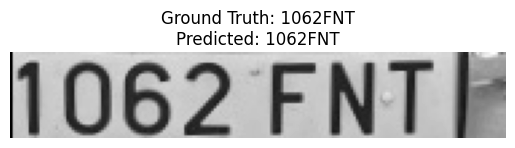

Processed Plate: 1062FNT (frontal) | Predicted: 1062FNT


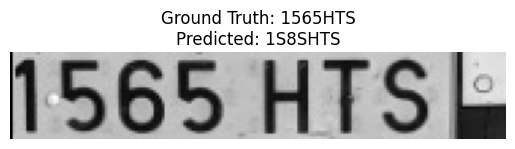

Processed Plate: 1565HTS (frontal) | Predicted: 1S8SHTS


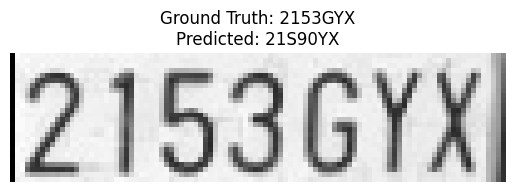

Processed Plate: 2153GYX (frontal) | Predicted: 21S90YX


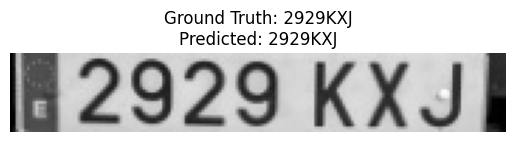

Processed Plate: 2929KXJ (frontal) | Predicted: 2929KXJ


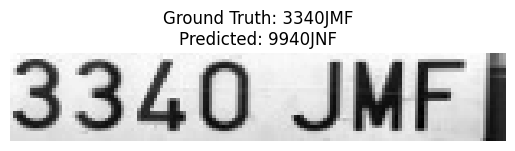

Processed Plate: 3340JMF (frontal) | Predicted: 9940JNF


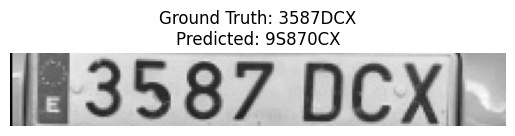

Processed Plate: 3587DCX (frontal) | Predicted: 9S870CX


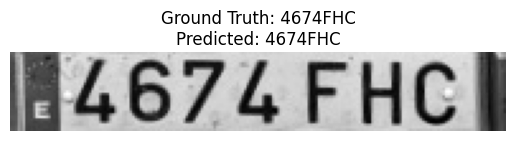

Processed Plate: 4674FHC (frontal) | Predicted: 4674FHC


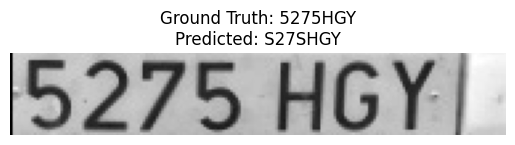

Processed Plate: 5275HGY (frontal) | Predicted: S27SHGY


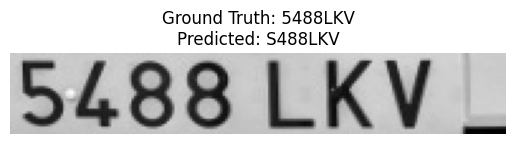

Processed Plate: 5488LKV (frontal) | Predicted: S488LKV


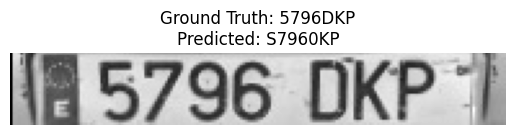

Processed Plate: 5796DKP (frontal) | Predicted: S7960KP


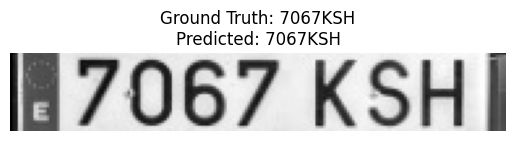

Processed Plate: 7067KSH (frontal) | Predicted: 7067KSH


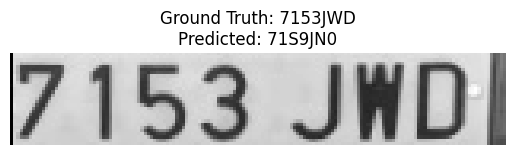

Processed Plate: 7153JWD (frontal) | Predicted: 71S9JN0


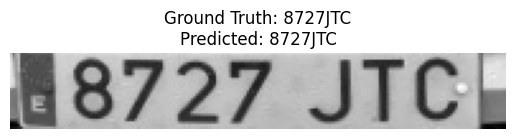

Processed Plate: 8727JTC (frontal) | Predicted: 8727JTC


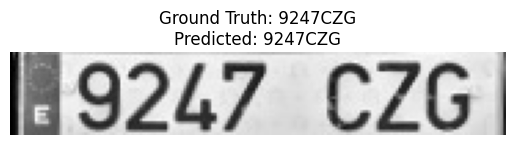

Processed Plate: 9247CZG (frontal) | Predicted: 9247CZG


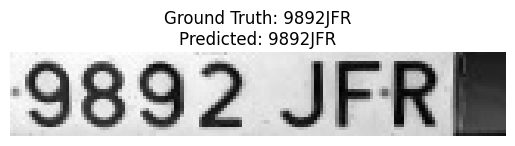

Processed Plate: 9892JFR (frontal) | Predicted: 9892JFR


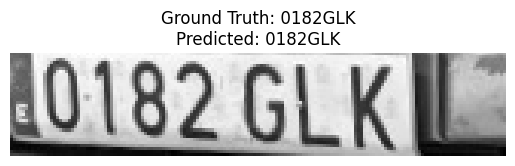

Processed Plate: 0182GLK (lateral) | Predicted: 0182GLK


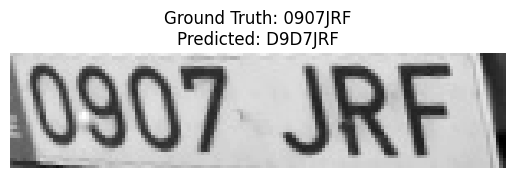

Processed Plate: 0907JRF (lateral) | Predicted: D9D7JRF


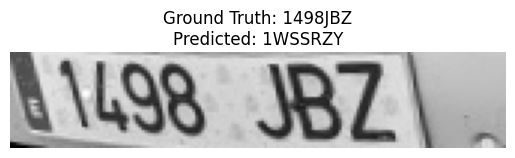

Processed Plate: 1498JBZ (lateral) | Predicted: 1WSSRZY


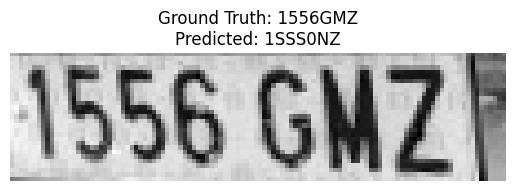

Processed Plate: 1556GMZ (lateral) | Predicted: 1SSS0NZ


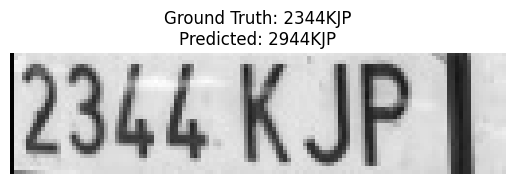

Processed Plate: 2344KJP (lateral) | Predicted: 2944KJP


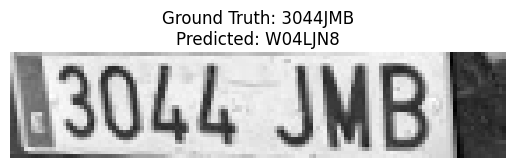

Processed Plate: 3044JMB (lateral) | Predicted: W04LJN8


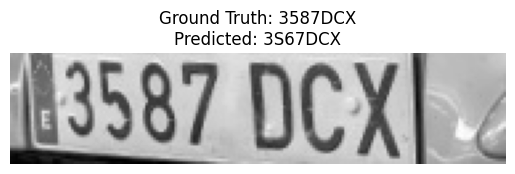

Processed Plate: 3587DCX (lateral) | Predicted: 3S67DCX


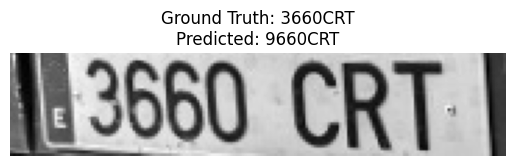

Processed Plate: 3660CRT (lateral) | Predicted: 9660CRT


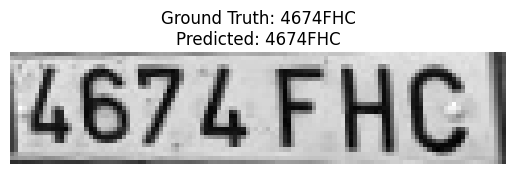

Processed Plate: 4674FHC (lateral) | Predicted: 4674FHC


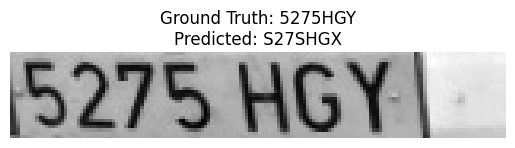

Processed Plate: 5275HGY (lateral) | Predicted: S27SHGX


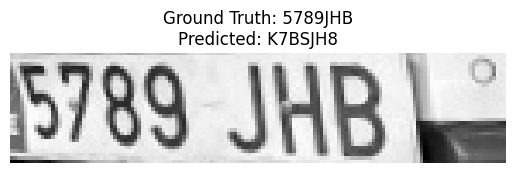

Processed Plate: 5789JHB (lateral) | Predicted: K7BSJH8


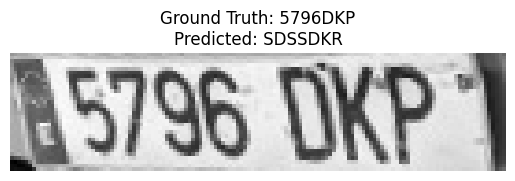

Processed Plate: 5796DKP (lateral) | Predicted: SDSSDKR


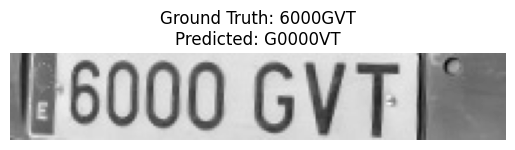

Processed Plate: 6000GVT (lateral) | Predicted: G0000VT


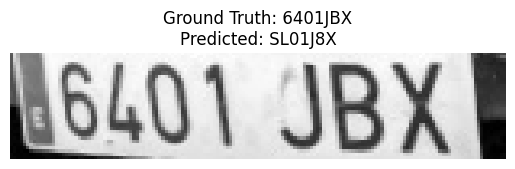

Processed Plate: 6401JBX (lateral) | Predicted: SL01J8X


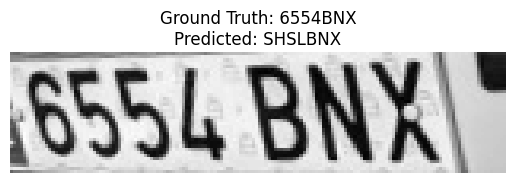

Processed Plate: 6554BNX (lateral) | Predicted: SHSLBNX


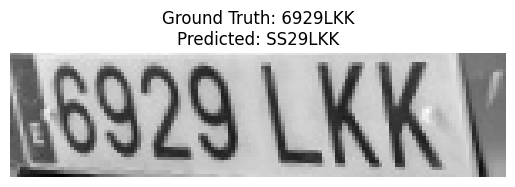

Processed Plate: 6929LKK (lateral) | Predicted: SS29LKK


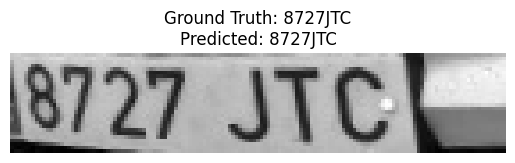

Processed Plate: 8727JTC (lateral) | Predicted: 8727JTC

Character-Level Accuracy: 70.98% (159 correct out of 224)


In [39]:
#paths to PlateDigits and PlateImages folders
plate_digits_folder = 'PlateDigits'  # Contains 'frontal' and 'lateral' with blobs
plate_images_folder = 'PlateImages'  # Contains full plate images

#run the function to process and visualize all plates and compute accuracy
process_all_plates(plate_digits_folder, plate_images_folder, knn, label_encoder)